In [1]:
import os
import pickle
import pandas as pd
import re
import json
from pydantic import BaseModel
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from refresh_db import ImmaculateGridResult, ImmaculateGridUtils
import numpy as np
from copy import deepcopy 
from typing import Dict, List, Tuple, Any


In [3]:
INPUT_GRID_RESULTS_FILE_PATH = '~/Desktop/GitHub/immaculate_grid_mlb_analysis/results.csv'
INPUT_PROMPT_DATA_PATH = '~/Desktop/GitHub/immaculate_grid_mlb_analysis/immaculate_grid_prompt_data.csv'
COLOR_MAP = {"Sam": "red", "Keith": "blue", "Will": "purple", "Rachel": "green", "Cliff": "orange"}

# Expand user directory and open the pickle file
data = pd.read_csv(INPUT_GRID_RESULTS_FILE_PATH, index_col=False)
texts = ImmaculateGridUtils.df_to_immaculate_grid_objs(data)

# Get the current grid number by selecting the max grid number from all ImmaculateGridResult objects for each person
current_grid_number = max(
    [
        max(
            [ImmaculateGridUtils.extract_grid_number_from_text(result.text) for result in texts[person] if ImmaculateGridUtils.extract_grid_number_from_text(result.text) is not None]
        )
        for person in texts
    ]
)

# Make a dictionary called "reversed_dict" that is the reverse of texts
# Initialize the reversed dictionary
reversed_dict = {}

# Iterate over each name and the list of grid objects
for name, grid_objects in texts.items():
    for grid_obj in grid_objects:
        # Extract the grid number from the text field of the object
        grid_number = ImmaculateGridUtils.extract_grid_number_from_text(grid_obj.text)

        if grid_number is not None:
            # Set up the reversed dictionary so that the grid number points to the player and their result
            reversed_dict.setdefault(grid_number, {})[name] = grid_obj

### --- Make a dataframe for score, correctness, and average_score_of_correct

# Initialize an empty list to store rows
rows = []

# Loop through the texts to gather data
for person, grid_objects in texts.items():
    for grid_obj in grid_objects:
        # Extract the grid number from the text field of the object
        grid_number = ImmaculateGridUtils.extract_grid_number_from_text(grid_obj.text)
        
        if grid_number is not None:
            # Calculate average rarity
            total_score_of_correct_squares = grid_obj.score - (100 * (9 - grid_obj.correct))
            if grid_obj.correct == 0:
                average_score_of_correct_squares = 100
            else:
                average_score_of_correct_squares = total_score_of_correct_squares / grid_obj.correct
            
            # Produce dataset
            row = {
                "grid_number": grid_number,  # Use a colon here
                "name": grid_obj.name,
                "correct": grid_obj.correct,
                "score": grid_obj.score,
                "average_score_of_correct": average_score_of_correct_squares,
                "date": grid_obj.date,
                "matrix": grid_obj.matrix
            }
            rows.append(row)  # Append the row to the list

# Create the DataFrame from the list of rows
analysis_df = pd.DataFrame(rows)

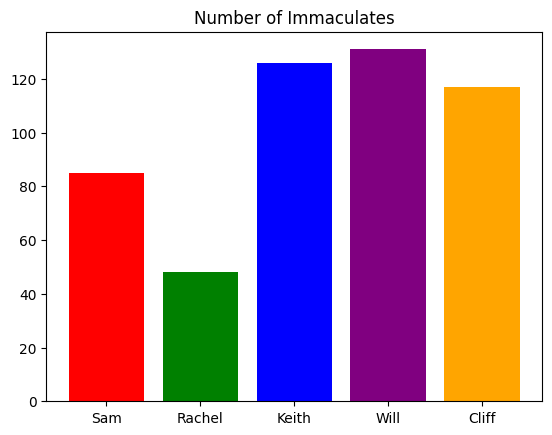

In [10]:
# Graph number of immaculates
counts = []
for person in texts:
    data = [(1 if obj.correct == 9 else 0) for obj in texts[person]]
    counts.append(sum(data))
plt.bar([person for person in texts], counts, color=[COLOR_MAP[person] for person in texts])
plt.title("Number of Immaculates")
plt.show()

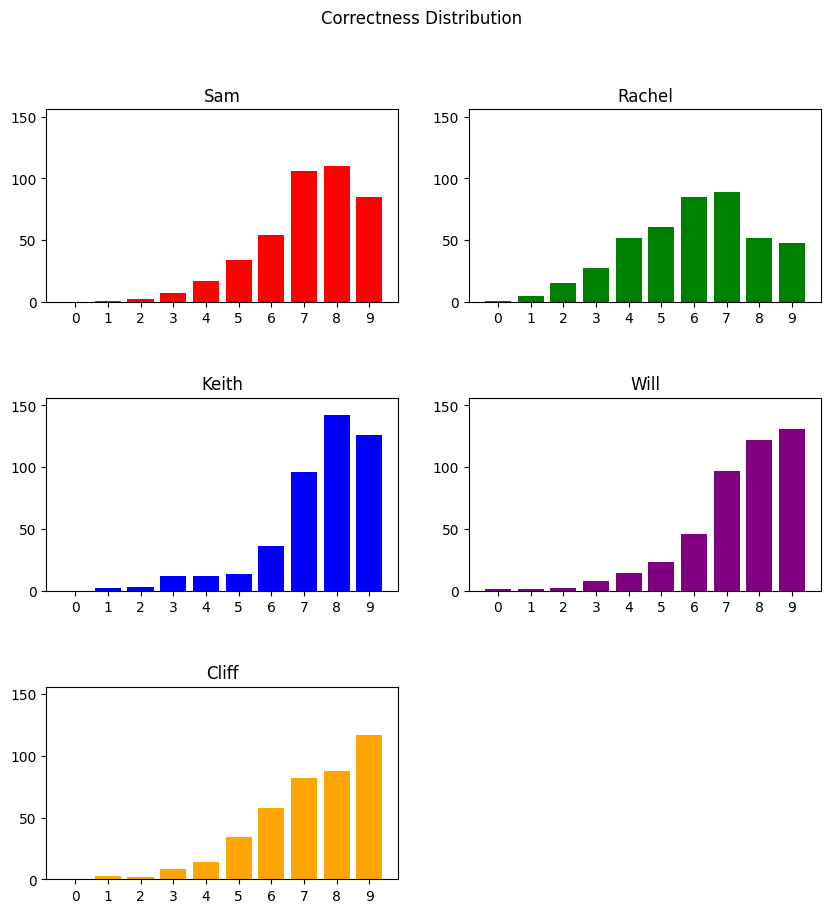

In [51]:
# Graph distributions
fig, axs = plt.subplots(3, 2, figsize=(10, 10))  # Create a 3x2 grid for 5 plots
top_bar = 130

# Flatten the axes array for easier indexing
axs = axs.flatten()

for i, person in enumerate(texts):
    distribution = [0 for _ in range(0, 10)]
    for row in texts[person]:
        distribution[row.correct] += 1
    
    # Plotting the distribution for each person
    axs[i].bar(range(0, 10), distribution, color=COLOR_MAP[person])
    axs[i].set_xticks(range(0, 10))
    axs[i].set_title(person)
    axs[i].set_ylim(0, 1.2*top_bar)

# Hide the last subplot if it is not used
if len(texts) < 6:
    axs[5].set_visible(False)

fig.suptitle("Correctness Distribution")
plt.subplots_adjust(hspace=0.5)
plt.show()


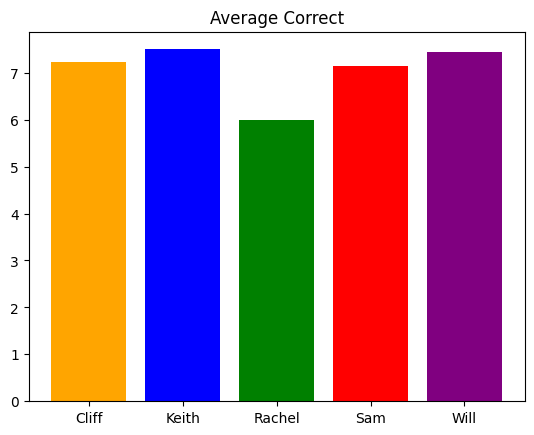

In [13]:
# Graph average correct
title = "Average Correct"
analysis_summary = analysis_df.groupby('name')['correct'].mean().reset_index()

plt.bar(
    analysis_summary.name, 
    analysis_summary.correct, 
    color=[COLOR_MAP[person] for person in analysis_summary.name])
plt.title(title)
plt.show()

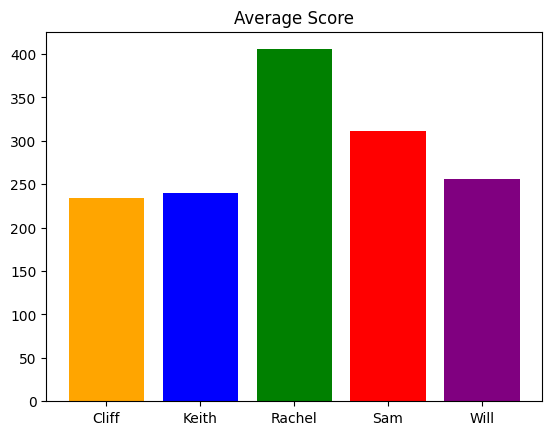

In [14]:
# Graph average score
title = "Average Score"
analysis_summary = analysis_df.groupby('name')['score'].mean().reset_index()

plt.bar(
    analysis_summary.name, 
    analysis_summary.score, 
    color=[COLOR_MAP[person] for person in analysis_summary.name])
plt.title(title)
plt.show()

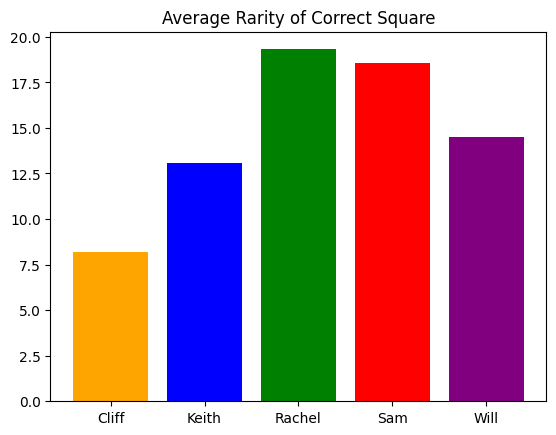

In [15]:
# Graph average rarity of correct s
title = "Average Rarity of Correct Square"
analysis_summary = analysis_df.groupby('name')['average_score_of_correct'].mean().reset_index()

plt.bar(
    analysis_summary.name, 
    analysis_summary.average_score_of_correct, 
    color=[COLOR_MAP[person] for person in analysis_summary.name])
plt.title(title)
plt.show()

In [16]:
# Ensure the 'date' column is in datetime format
analysis_df['date'] = pd.to_datetime(analysis_df['date'])

# Function to calculate smoothed metrics (score, correct, average_score_of_correct) from analysis_df
def calculate_smoothed_metrics(analysis_df: pd.DataFrame, smoothness: int) -> pd.DataFrame:
    """Generate a DataFrame of smoothed scores, correct values, and average scores over time."""
    metric_table = []

    # Group the data by 'name' to process each person individually
    grouped = analysis_df.groupby('name')

    # Loop through each person
    for name, group in grouped:
        group = group.sort_values(by='date')  # Sort by date to ensure time-based smoothing
        scores = group['score'].tolist()  # Extract scores
        corrects = group['correct'].tolist()  # Extract correct values
        avg_scores = group['average_score_of_correct'].tolist()  # Extract average score of correct
        dates = group['date'].tolist()  # Extract dates

        # Apply smoothing with the specified window size
        for i in range(smoothness, len(scores)):
            # Extract windows of each metric
            score_window = scores[i - smoothness:i]
            correct_window = corrects[i - smoothness:i]
            avg_score_window = avg_scores[i - smoothness:i]
            
            # Calculate smoothed values for each metric
            valid_scores = [score for score in score_window if score is not None]
            valid_corrects = [correct for correct in correct_window if correct is not None]
            valid_avg_scores = [avg_score for avg_score in avg_score_window if avg_score is not None]

            smoothed_score = sum(valid_scores) / len(valid_scores) if valid_scores else None
            smoothed_correct = sum(valid_corrects) / len(valid_corrects) if valid_corrects else None
            smoothed_avg_score = sum(valid_avg_scores) / len(valid_avg_scores) if valid_avg_scores else None
            smoothed_date = dates[i] if i < len(dates) else None

            # Only add rows where there are valid smoothed values
            if smoothed_score is not None and smoothed_correct is not None and smoothed_avg_score is not None:
                metric_table.append({
                    'name': name,
                    'grid_number': i,  # Could be i, or a corresponding column like group['grid_number']
                    'smoothed_score': smoothed_score,
                    'smoothed_correct': smoothed_correct,
                    'smoothed_avg_score': smoothed_avg_score,
                    'date': smoothed_date
                })

    # Create a DataFrame from the smoothed data
    return pd.DataFrame(metric_table, columns=["name", "grid_number", "smoothed_score", "smoothed_correct", "smoothed_avg_score", "date"]).dropna()

# Function to plot smoothed metrics using the smoothed DataFrame
def plot_smoothed_metrics(smoothed_df: pd.DataFrame, metric: str, title: str, ylabel: str) -> None:
    """Plot the smoothed metrics (score, correct, or average score) over time."""
    plt.figure(figsize=(12, 6))

    # Plot smoothed metrics for each person
    for name in smoothed_df['name'].unique():
        person_data = smoothed_df[smoothed_df['name'] == name]
        
        # Plot line with proper date formatting for the selected metric
        plt.plot(person_data['date'], person_data[metric], label=name, color=COLOR_MAP.get(name, 'blue'))

    # Formatting the plot
    plt.legend()
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)

    # Adjust x-axis date formatting and tick placement
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))  # Format to month and year
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))  # Limit number of x-ticks to avoid clutter

    plt.tight_layout()  # Adjust layout for better display
    plt.show()

# Example Usage:
# Calculate the smoothed metrics from the DataFrame
smoothness = 28
smoothed_metrics_df = calculate_smoothed_metrics(analysis_df, smoothness)

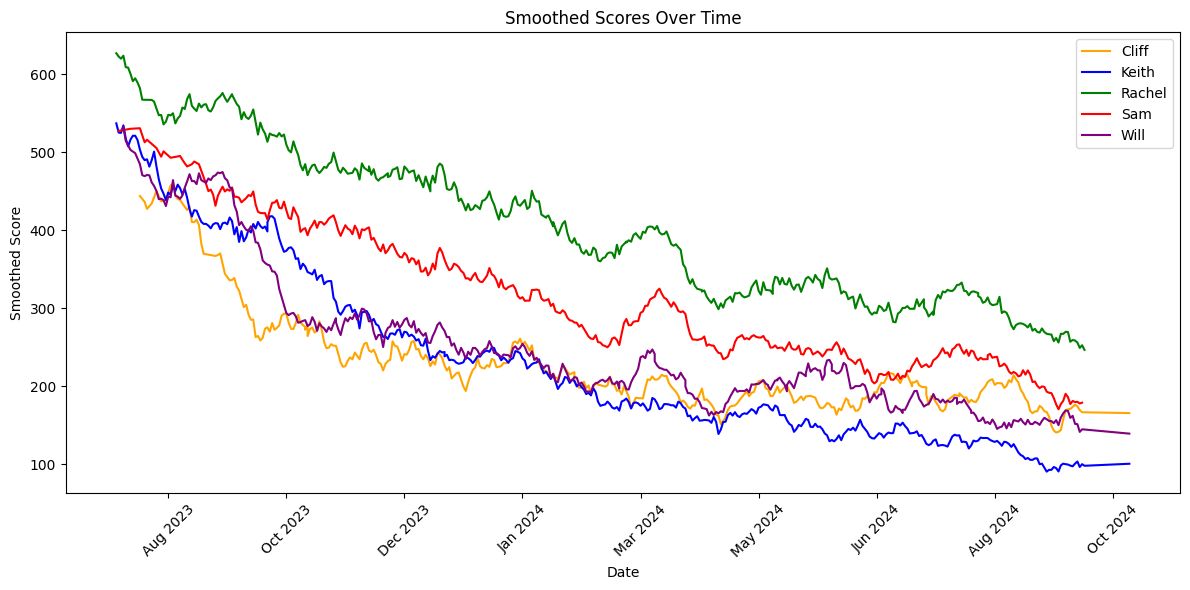

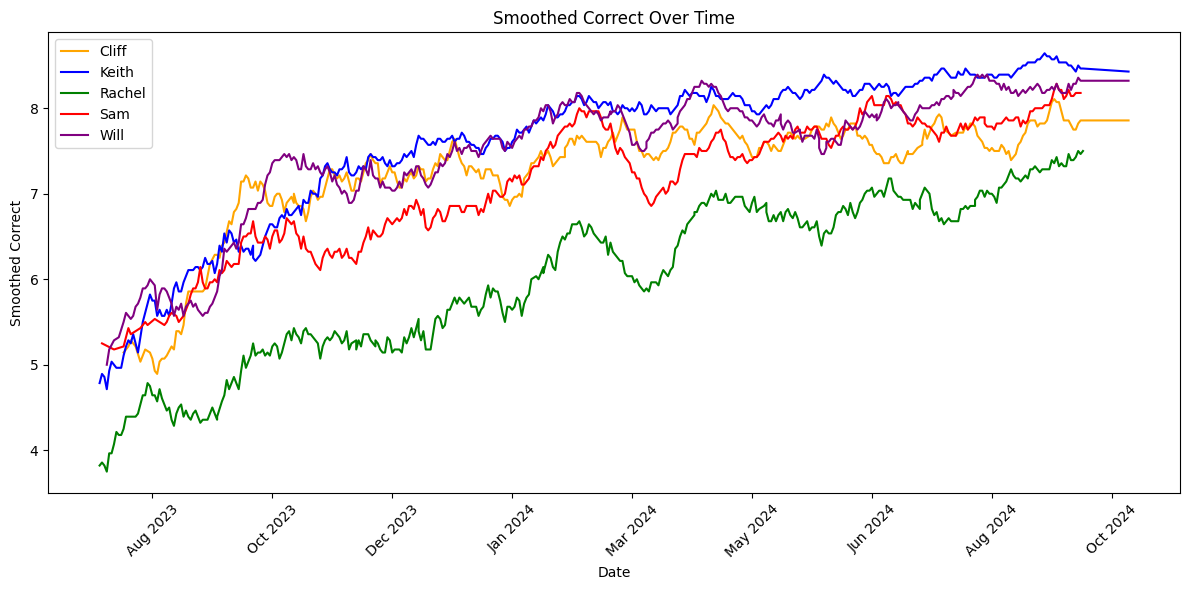

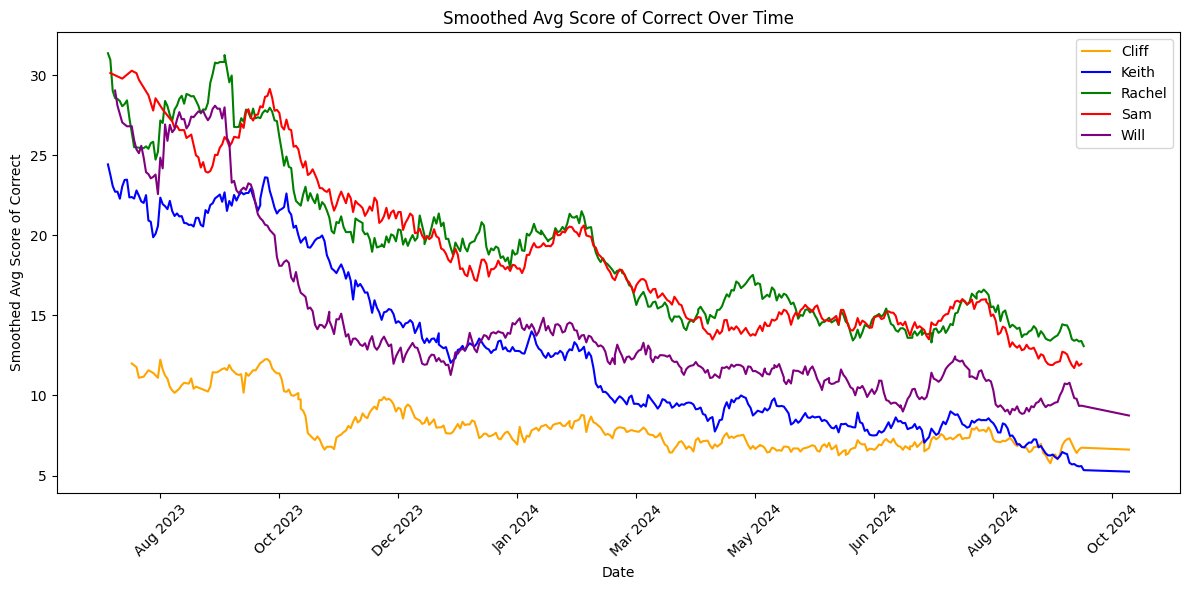

In [17]:
# Plot each metric separately
plot_smoothed_metrics(smoothed_metrics_df, 'smoothed_score', "Smoothed Scores Over Time", "Smoothed Score")
plot_smoothed_metrics(smoothed_metrics_df, 'smoothed_correct', "Smoothed Correct Over Time", "Smoothed Correct")
plot_smoothed_metrics(smoothed_metrics_df, 'smoothed_avg_score', "Smoothed Avg Score of Correct Over Time", "Smoothed Avg Score of Correct")


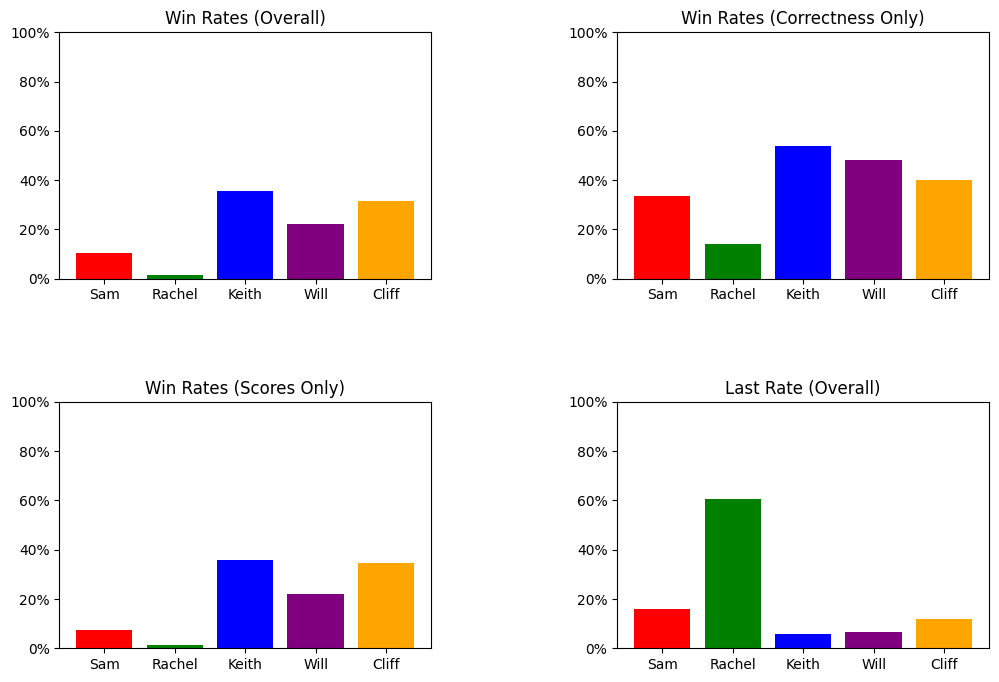

In [19]:
def to_percent(y, position):
    """Convert a decimal to a percentage string."""
    return f"{100 * y:.0f}%"

def calculate_win_rates(reversed_dict, criterion):
    """
    Calculate win rates based on a given criterion.

    Args:
        reversed_dict (dict): The games data.
        criterion (str): The criterion to calculate win rates ("overall", "correctness", "scores", "last_rate").

    Returns:
        dict: A dictionary of win rates for each person.
    """
    wins = {person: 0 for person in texts}
    for game in reversed_dict.values():
        if criterion == "overall":
            best = max((game[person].correct * 1000) + (1000 - game[person].score) for person in game)
            for person in game:
                effective_score = (game[person].correct * 1000) + (1000 - game[person].score)
                if effective_score == best:
                    wins[person] += 1
        elif criterion == "correctness":
            best = max(game[person].correct for person in game)
            for person in game:
                if game[person].correct == best:
                    wins[person] += 1
        elif criterion == "scores":
            best = min(game[person].score for person in game)
            for person in game:
                if game[person].score == best:
                    wins[person] += 1
        elif criterion == "last_rate":
            best = min((game[person].correct * 1000) + (1000 - game[person].score) for person in game)
            for person in game:
                effective_score = (game[person].correct * 1000) + (1000 - game[person].score)
                if effective_score == best:
                    wins[person] += 1

    for person in wins:
        wins[person] /= len(reversed_dict.values())

    return wins

def plot_win_rates(reversed_dict):
    """Plot win rates based on various criteria."""
    # Set a larger figure size to widen the graphs
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    criteria = ["overall", "correctness", "scores", "last_rate"]
    titles = ["Win Rates (Overall)", "Win Rates (Correctness Only)", "Win Rates (Scores Only)", "Last Rate (Overall)"]

    for ax, criterion, title in zip(axs.flat, criteria, titles):
        wins = calculate_win_rates(reversed_dict, criterion)
        ax.bar([person for person in wins], wins.values(), color=[COLOR_MAP[person] for person in wins])
        ax.set_title(title)
        ax.set_yticks([i / 5 for i in range(6)])
        ax.set_ylim(0, 1)
        ax.yaxis.set_major_formatter(FuncFormatter(to_percent))

    # Adjust the layout of the subplots
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.show()

# Usage
plot_win_rates(reversed_dict)


In [24]:
score_records = []
for person, games in texts.items():
    for game in games:
        id = ImmaculateGridUtils.extract_grid_number_from_text(game.text)
        score_records.append((person, game.score, game.date, id))

print("Best:")
sorted_records = sorted(score_records, key=lambda x: x[1])
for i, (name, record, date, game_id) in enumerate(sorted_records[0:25]):
    print(i + 1, name, record, date)

print("\n\nWorst:")
for i in range(25):
    name, record, date, game_id = sorted_records[len(sorted_records) - i - 1]
    print(i + 1, name, record, date)

Best:
1 Keith 4 2024-06-14
2 Will 4 2024-09-21
3 Cliff 5 2024-01-29
4 Cliff 6 2023-11-24
5 Keith 8 2024-06-28
6 Will 8 2024-07-13
7 Cliff 8 2023-12-09
8 Keith 9 2024-09-14
9 Will 9 2023-10-28
10 Cliff 9 2024-07-13
11 Will 10 2024-01-15
12 Will 10 2024-09-07
13 Cliff 10 2024-03-16
14 Cliff 10 2024-06-02
15 Cliff 11 2024-03-30
16 Cliff 11 2024-09-21
17 Will 12 2024-04-27
18 Cliff 12 2024-01-15
19 Cliff 12 2024-09-06
20 Keith 13 2024-08-03
21 Cliff 13 2024-08-01
22 Keith 14 2024-07-21
23 Will 14 2024-06-14
24 Cliff 14 2023-10-28
25 Rachel 15 2024-07-13


Worst:
1 Will 900 2023-09-01
2 Rachel 900 2023-09-01
3 Rachel 891 2023-08-30
4 Rachel 852 2023-11-20
5 Rachel 833 2023-07-15
6 Keith 828 2023-08-30
7 Cliff 825 2023-08-10
8 Will 825 2023-07-28
9 Rachel 825 2023-12-22
10 Rachel 825 2023-07-28
11 Rachel 823 2023-08-01
12 Will 821 2023-07-15
13 Keith 821 2023-07-15
14 Sam 821 2023-07-15
15 Sam 817 2023-11-02
16 Cliff 816 2023-09-01
17 Rachel 806 2023-12-28
18 Will 805 2023-07-21
19 Keith 805

In [25]:
##### Everything below this line incorporates prompt data

with open(os.path.expanduser(INPUT_PROMPT_DATA_PATH)) as f:
    prompt_df = pd.read_csv(f, header=None)
prompt_df.columns = ["game_id", "00", "01", "02", "10", "11", "12", "20", "21", "22"]
prompt_df = prompt_df.iloc[1:]

new_rows = []
for i, row in prompt_df.iterrows():
    new_row = {}
    for col, val in row.items():
        for char in ["(", "'", ")"]:
            val = val.replace(char, "")
        new_row[col] = val.replace(", ", " + ")
    new_rows.append(new_row)
        

prompt_df = pd.DataFrame(new_rows)
prompt_df['game_id'] = prompt_df['game_id'].astype(int)

In [26]:
team_list = ["Cubs", "Cardinals", "Brewers", "Reds", "Pirates", "Nationals", "Mets", "Marlins", "Phillies", "Braves", "Dodgers", "Diamondbacks", "Rockies", "Giants", "Padres", "Royals", "White Sox", "Twins", "Guardians", "Tigers", "Red Sox", "Yankees", "Blue Jays", "Rays", "Orioles", "Angels", "Athletics", "Astros", "Mariners", "Rangers"]

def is_team(category):
    for team in team_list:
        if team in category:
            return True
    return False

def get_team(category):
    for team in team_list:
        if team in category:
            return team
    return ""

In [28]:
def get_categories(prompt):
    parts = prompt.split(" + ")
    return parts[0].strip(), parts[1].strip()

categories = set()
for person, games in texts.items():
    for game in games:
        id = ImmaculateGridUtils.extract_grid_number_from_text(game.text)
        prompt_rows = prompt_df[prompt_df["game_id"] == id]
        if len(prompt_rows) != 1:
            continue
        prompts = prompt_rows.iloc[0][1:]
        for prompt in prompts:
            part_one, part_two = get_categories(prompt)
            categories.add(part_one)
            categories.add(part_two)

person_to_category = {}
for person, _ in texts.items():
    person_to_category[person] = {cat: [0, 0] for cat in categories}

In [29]:
for person, games in texts.items():
    for game in games:
        id = ImmaculateGridUtils.extract_grid_number_from_text(game.text)
        prompt_rows = prompt_df[prompt_df["game_id"] == id]
        if len(prompt_rows) != 1:
            continue
        prompts = prompt_rows.iloc[0][1:]

        matrix = game.matrix
        for i in range(3):
            for j in range(3):
                part_one, part_two = get_categories(prompts[f"{i}{j}"])
                if matrix[i][j]:
                    person_to_category[person][part_one][0] += 1
                    person_to_category[person][part_two][0] += 1
                person_to_category[person][part_one][1] += 1
                person_to_category[person][part_two][1] += 1

In [30]:
threshold = 25
categories_to_count = {}
for category in categories:
    categories_to_count[category] = []
for _, value in person_to_category.items():
    for category, (correct, total) in value.items():
        categories_to_count[category].append(total)
categories_clearing_threshold = [cat for cat in filter(lambda x: sum(categories_to_count[x]) / len(categories_to_count[x]) > threshold, categories_to_count)]


In [32]:
types = ["Team-Team", "Team-Stat", "Stat-Stat"]
person_to_type = {person: {t: [0, 0] for t in types} for person in person_to_category}

for person, games in texts.items():
    for game in games:
        id = ImmaculateGridUtils.extract_grid_number_from_text(game.text)
        prompt_rows = prompt_df[prompt_df["game_id"] == id]
        if len(prompt_rows) != 1:
            continue
        prompts = prompt_rows.iloc[0][1:]

        matrix = game.matrix
        for i in range(3):
            for j in range(3):
                part_one, part_two = get_categories(prompts[f"{i}{j}"])
                tag = ""
                if is_team(part_one) and is_team(part_two):
                    tag = "Team-Team"
                elif is_team(part_one) != is_team(part_two):
                    tag = "Team-Stat"
                else:
                    tag = "Stat-Stat"
                if matrix[i][j]:
                    person_to_type[person][tag][0] += 1
                person_to_type[person][tag][1] += 1

In [33]:
for person in person_to_type:
    print(person)
    for tag in person_to_type[person]:
        acc = person_to_type[person][tag][0] / person_to_type[person][tag][1]
        print(f"{tag}: {round(100 * acc)}% ({person_to_type[person][tag][1]})")
    print()

Sam
Team-Team: 59% (1278)
Team-Stat: 89% (1602)
Stat-Stat: 92% (441)

Rachel
Team-Team: 38% (1366)
Team-Stat: 79% (1663)
Stat-Stat: 92% (454)

Keith
Team-Team: 75% (1404)
Team-Stat: 85% (1677)
Stat-Stat: 91% (456)

Will
Team-Team: 66% (1395)
Team-Stat: 90% (1701)
Stat-Stat: 95% (477)

Cliff
Team-Team: 62% (1261)
Team-Stat: 90% (1567)
Stat-Stat: 96% (421)



In [34]:
for person, value in person_to_category.items():
    rankings = sorted([(cat, value[cat][0] / value[cat][1], value[cat][1]) for cat in value], key=lambda x: x[1], reverse=True)

    print(f"====={person}=====")
    count = 1
    for i, (category, accuracy, total) in enumerate(rankings):
        if total > threshold:
            print(f"{count}. {category} ({round(accuracy, 2)}) ({total})")
            count += 1
    print("\n\n")

=====Sam=====
1. 40+ WAR Career (1.0) (57)
2. All Star (1.0) (129)
3. 100+ Run Season Batting (1.0) (48)
4. 100+ RBI Season Batting (0.99) (84)
5. MVP (0.98) (66)
6. ≤ 3.00 ERA Season (0.98) (60)
7. 6+ WAR Season (0.98) (54)
8. First Round Draft Pick (0.98) (48)
9. 10+ Win Season Pitching (0.98) (48)
10. Played Outfield min. 1 game (0.98) (42)
11. Hall of Fame (0.97) (117)
12. Pitched min. 1 game (0.97) (36)
13. 30+ HR Season Batting (0.96) (57)
14. .300+ AVG Season Batting (0.96) (78)
15. 2000+ K Career Pitching (0.96) (48)
16. Silver Slugger (0.96) (69)
17. Only One Team (0.95) (66)
18. 2000+ Hits Career Batting (0.95) (66)
19. 300+ HR Career Batting (0.95) (63)
20. Chicago Cubs (0.95) (147)
21. Played Right Field min. 1 game (0.95) (39)
22. Played Third Base min. 1 game (0.94) (48)
23. Born Outside US 50 States and DC (0.93) (75)
24. 40+ HR Season Batting (0.93) (54)
25. Played Center Field min. 1 game (0.9) (42)
26. New York Yankees (0.89) (171)
27. Played Left Field min. 1 game (0

In [35]:
overall = []
for category in categories:
    values = []
    counts = []
    for person in person_to_category:
        values.append(person_to_category[person][category][0] / person_to_category[person][category][1])
        counts.append(person_to_category[person][category][1])
    if is_team(category):
        overall.append((category, sum(values) / len(values)))

print("Consensus Easiest Teams")
overall = sorted(overall, key=lambda x: x[1], reverse=True)
for i, (category, avg) in enumerate(overall):
    print(f"{(i + 1)}. {category} ({round(100 * avg)}%)")

Consensus Easiest Teams
1. New York Yankees (89%)
2. Chicago Cubs (88%)
3. New York Mets (88%)
4. Boston   Red Sox (83%)
5. Los Angeles Dodgers (81%)
6. Washington Nationals (80%)
7. Oakland Athletics (75%)
8. Texas Rangers (74%)
9. Atlanta Braves (74%)
10. Houston Astros (73%)
11. Philadelphia Phillies (72%)
12. St. Louis Cardinals (72%)
13. San Francisco Giants (72%)
14. Cincinnati Reds (70%)
15. Los Angeles Angels (67%)
16. Cleveland Guardians (66%)
17. Baltimore Orioles (66%)
18. Chicago  White Sox (66%)
19. Pittsburgh Pirates (65%)
20. Detroit Tigers (64%)
21. San Diego Padres (62%)
22. Minnesota Twins (62%)
23. Toronto  Blue Jays (61%)
24. Milwaukee Brewers (60%)
25. Seattle Mariners (60%)
26. Kansas City Royals (59%)
27. Miami Marlins (54%)
28. Arizona Diamondbacks (54%)
29. Colorado Rockies (50%)
30. Tampa Bay Rays (49%)


In [36]:
overall = []
for category in categories:
    values = []
    counts = []
    for person in person_to_category:
        values.append(person_to_category[person][category][0] / person_to_category[person][category][1])
        counts.append(person_to_category[person][category][1])
    if is_team(category):
        overall.append((category, np.std(values)))

print("Biggest Team Standard Deviations")
overall = sorted(overall, key=lambda x: x[1], reverse=True)
for i, (category, avg) in enumerate(overall):
    print(f"{(i + 1)}. {category} ({round(100 * avg)}%)")

Biggest Team Standard Deviations
1. Tampa Bay Rays (18%)
2. Arizona Diamondbacks (17%)
3. Miami Marlins (14%)
4. Baltimore Orioles (14%)
5. San Diego Padres (13%)
6. Minnesota Twins (13%)
7. Milwaukee Brewers (12%)
8. Pittsburgh Pirates (12%)
9. San Francisco Giants (12%)
10. Philadelphia Phillies (12%)
11. Seattle Mariners (12%)
12. Oakland Athletics (11%)
13. Cincinnati Reds (11%)
14. Atlanta Braves (11%)
15. Toronto  Blue Jays (11%)
16. Kansas City Royals (10%)
17. Los Angeles Angels (10%)
18. Detroit Tigers (10%)
19. Los Angeles Dodgers (10%)
20. Cleveland Guardians (10%)
21. Houston Astros (9%)
22. Texas Rangers (9%)
23. St. Louis Cardinals (9%)
24. Chicago Cubs (8%)
25. New York Yankees (8%)
26. Colorado Rockies (7%)
27. New York Mets (7%)
28. Boston   Red Sox (6%)
29. Washington Nationals (6%)
30. Chicago  White Sox (6%)


In [37]:
overall = []
for category in filter(is_team, categories):

    max_acc = 0
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if acc > max_acc:
            max_acc = acc

    max_people = []
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if abs(acc - max_acc) < 0.0001:
            max_people.append(person)
    
    overall.append((category, ", ".join(max_people)))

print("Best Person for Each Team")
for category, people in sorted(overall, key=lambda x: x[0]):
    print(category, "\t" if len(category) > 14 else "\t\t", people)
    


Best Person for Each Team
Arizona Diamondbacks 	 Keith
Atlanta Braves 		 Cliff
Baltimore Orioles 	 Keith
Boston   Red Sox 	 Keith
Chicago  White Sox 	 Will
Chicago Cubs 		 Will
Cincinnati Reds 	 Cliff
Cleveland Guardians 	 Will
Colorado Rockies 	 Keith
Detroit Tigers 		 Keith
Houston Astros 		 Keith
Kansas City Royals 	 Keith
Los Angeles Angels 	 Keith
Los Angeles Dodgers 	 Keith
Miami Marlins 		 Keith
Milwaukee Brewers 	 Keith
Minnesota Twins 	 Keith
New York Mets 		 Keith
New York Yankees 	 Cliff
Oakland Athletics 	 Cliff
Philadelphia Phillies 	 Keith
Pittsburgh Pirates 	 Will
San Diego Padres 	 Keith
San Francisco Giants 	 Keith
Seattle Mariners 	 Keith
St. Louis Cardinals 	 Keith
Tampa Bay Rays 		 Keith
Texas Rangers 		 Will
Toronto  Blue Jays 	 Keith
Washington Nationals 	 Keith


In [38]:
overall = []
for category in filter(is_team, categories):

    min_acc = 101
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if acc < min_acc:
            min_acc = acc

    min_people = []
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if abs(acc - min_acc) < 0.0001:
            min_people.append(person)
    
    overall.append((category, ", ".join(min_people)))

print("Worst Person for Each Team")
for category, people in sorted(overall, key=lambda x: x[0]):
    print(category, "\t" if len(category) > 14 else "\t\t", people)
    

Worst Person for Each Team
Arizona Diamondbacks 	 Cliff
Atlanta Braves 		 Rachel
Baltimore Orioles 	 Rachel
Boston   Red Sox 	 Rachel
Chicago  White Sox 	 Rachel
Chicago Cubs 		 Cliff
Cincinnati Reds 	 Rachel
Cleveland Guardians 	 Rachel
Colorado Rockies 	 Rachel
Detroit Tigers 		 Rachel
Houston Astros 		 Rachel
Kansas City Royals 	 Rachel
Los Angeles Angels 	 Rachel
Los Angeles Dodgers 	 Rachel
Miami Marlins 		 Cliff
Milwaukee Brewers 	 Rachel
Minnesota Twins 	 Rachel
New York Mets 		 Rachel
New York Yankees 	 Rachel
Oakland Athletics 	 Rachel
Philadelphia Phillies 	 Rachel
Pittsburgh Pirates 	 Rachel
San Diego Padres 	 Rachel
San Francisco Giants 	 Rachel
Seattle Mariners 	 Rachel
St. Louis Cardinals 	 Rachel
Tampa Bay Rays 		 Cliff
Texas Rangers 		 Rachel
Toronto  Blue Jays 	 Rachel
Washington Nationals 	 Rachel


In [40]:
overall = []
for category in filter(lambda x: not is_team(x) and x in categories_clearing_threshold, categories):

    max_acc = 0
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if acc > max_acc:
            max_acc = acc

    max_people = []
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if abs(acc - max_acc) < 0.0001:
            max_people.append(person)
    
    overall.append((category, ", ".join(max_people)))

print("Best Person for Each Category")
for category, people in sorted(overall, key=lambda x: x[0]):
    print(category, "\t" if len(category) > 14 else "\t\t", people)
    

Best Person for Each Category
.300+ AVG Career Batting 	 Will
.300+ AVG Season Batting 	 Will
10+ Win Season Pitching 	 Will
100+ RBI Season Batting 	 Sam
100+ Run Season Batting 	 Sam
20+ Win Season Pitching 	 Cliff
200+ Hits Season Batting 	 Cliff
200+ K Season Pitching 	 Will
200+ Wins Career Pitching 	 Keith, Will, Cliff
2000+ Hits Career Batting 	 Cliff
2000+ K Career Pitching 	 Will, Cliff
30+ HR Season Batting 	 Rachel, Will
30+ SB Season 		 Will
30+ Save Season Pitching 	 Keith
300+ HR Career Batting 	 Keith, Cliff
3000+ Hits Career Batting 	 Will
40+ HR Season Batting 	 Will
40+ WAR Career 		 Sam, Rachel, Keith, Cliff
6+ WAR Season 		 Sam, Keith
All Star 		 Sam, Will
Born Outside US 50 States and DC 	 Will
Cy Young 		 Cliff
First Round Draft Pick 	 Sam
Gold Glove 		 Cliff
Hall of Fame 		 Keith
MVP 		 Will
Only One Team 		 Sam
Pitched min. 1 game 	 Will
Played Catcher min. 1 game 	 Keith
Played Center Field min. 1 game 	 Cliff
Played First Base min. 1 game 	 Keith, Cliff
Played

In [41]:
overall = []
for category in filter(lambda x: not is_team(x) and x in categories_clearing_threshold, categories):

    min_acc = 101
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if acc < min_acc:
            min_acc = acc

    min_people = []
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if abs(acc - min_acc) < 0.0001:
            min_people.append(person)
    
    overall.append((category, ", ".join(min_people)))

print("Worst Person for Each Category")
for category, people in sorted(overall, key=lambda x: x[0]):
    print(category, "\t" if len(category) > 14 else "\t\t", people)
    

Worst Person for Each Category
.300+ AVG Career Batting 	 Keith
.300+ AVG Season Batting 	 Rachel
10+ Win Season Pitching 	 Rachel
100+ RBI Season Batting 	 Rachel
100+ Run Season Batting 	 Rachel, Keith, Cliff
20+ Win Season Pitching 	 Rachel, Keith
200+ Hits Season Batting 	 Rachel
200+ K Season Pitching 	 Rachel
200+ Wins Career Pitching 	 Sam, Rachel
2000+ Hits Career Batting 	 Rachel
2000+ K Career Pitching 	 Rachel
30+ HR Season Batting 	 Cliff
30+ SB Season 		 Keith
30+ Save Season Pitching 	 Rachel
300+ HR Career Batting 	 Rachel
3000+ Hits Career Batting 	 Keith
40+ HR Season Batting 	 Rachel
40+ WAR Career 		 Will
6+ WAR Season 		 Rachel
All Star 		 Keith
Born Outside US 50 States and DC 	 Rachel
Cy Young 		 Rachel
First Round Draft Pick 	 Rachel
Gold Glove 		 Keith
Hall of Fame 		 Rachel
MVP 		 Keith
Only One Team 		 Rachel
Pitched min. 1 game 	 Cliff
Played Catcher min. 1 game 	 Rachel
Played Center Field min. 1 game 	 Rachel
Played First Base min. 1 game 	 Will
Played In M

In [43]:
hardest_teams = {}

for person, games in texts.items():
    hardest_teams[person] = {team: [0, 0] for team in team_list}
    for game in games:
        id = ImmaculateGridUtils.extract_grid_number_from_text(game.text)
        prompt_rows = prompt_df[prompt_df["game_id"] == id]
        if len(prompt_rows) != 1:
            continue
        prompts = prompt_rows.iloc[0][1:]

        matrix = game.matrix
        for i in range(3):
            for j in range(3):
                part_one, part_two = get_categories(prompts[f"{i}{j}"])
                tag = ""
                if is_team(part_one) and is_team(part_two):
                    team_one = get_team(part_one)
                    team_two = get_team(part_two)
                    if matrix[i][j]:
                        hardest_teams[person][team_one][0] += 1
                        hardest_teams[person][team_two][0] += 1
                    hardest_teams[person][team_one][1] += 1
                    hardest_teams[person][team_two][1] += 1

print("Hardest Team-Team Intersections for Each Person", "\n\n")
for person in hardest_teams:
    print(f"====={person}=====")
    for i, (team, res) in enumerate(sorted(hardest_teams[person].items(), key = lambda x: x[1][0] / x[1][1], reverse=True)):
        print(f"{i + 1}. {team} ({round(100 * res[0] / res[1])}%)")
    print("\n\n\n")

consensus_intersection_difficulty = {}
for team in team_list:
    right = 0
    total = 0
    for person in hardest_teams:
        res = hardest_teams[person][team]
        right += res[0]
        total += res[1]
    consensus_intersection_difficulty[team] = right / total
    
print("=====Consensus=====")
for i, (team, pct) in enumerate(sorted(consensus_intersection_difficulty.items(), key=lambda x: x[1], reverse=True)):
    print(f"{i + 1}. {team} ({round(100 * pct)}%)")


Hardest Team-Team Intersections for Each Person 


=====Sam=====
1. Cubs (98%)
2. Red Sox (84%)
3. Yankees (80%)
4. Dodgers (77%)
5. Mets (74%)
6. Rangers (73%)
7. Nationals (70%)
8. Athletics (68%)
9. Blue Jays (63%)
10. Astros (63%)
11. Reds (62%)
12. Guardians (59%)
13. Brewers (57%)
14. Phillies (57%)
15. Rays (56%)
16. Padres (56%)
17. Orioles (54%)
18. Braves (53%)
19. Royals (52%)
20. Tigers (51%)
21. Angels (51%)
22. Cardinals (49%)
23. Diamondbacks (49%)
24. White Sox (45%)
25. Twins (44%)
26. Pirates (44%)
27. Giants (44%)
28. Marlins (44%)
29. Mariners (40%)
30. Rockies (34%)




=====Rachel=====
1. Cubs (90%)
2. Mets (71%)
3. Nationals (60%)
4. Yankees (57%)
5. Red Sox (57%)
6. Rangers (48%)
7. Dodgers (47%)
8. Athletics (46%)
9. White Sox (44%)
10. Diamondbacks (38%)
11. Guardians (36%)
12. Rays (35%)
13. Cardinals (34%)
14. Phillies (34%)
15. Astros (33%)
16. Giants (33%)
17. Padres (33%)
18. Reds (32%)
19. Braves (31%)
20. Angels (30%)
21. Marlins (30%)
22. Blue Jays (29

In [45]:
hardest_team_stats = {}

for person, games in texts.items():
    hardest_team_stats[person] = {team: [0, 0] for team in team_list}
    for game in games:
        id = ImmaculateGridUtils.extract_grid_number_from_text(game.text)
        prompt_rows = prompt_df[prompt_df["game_id"] == id]
        if len(prompt_rows) != 1:
            continue
        prompts = prompt_rows.iloc[0][1:]

        matrix = game.matrix
        for i in range(3):
            for j in range(3):
                part_one, part_two = get_categories(prompts[f"{i}{j}"])
                tag = ""
                if is_team(part_one) and not is_team(part_two):
                    team_one = get_team(part_one)
                    if matrix[i][j]:
                        hardest_team_stats[person][team_one][0] += 1
                    hardest_team_stats[person][team_one][1] += 1
                elif not is_team(part_one) and is_team(part_two):
                    team_two = get_team(part_two)
                    if matrix[i][j]:
                        hardest_team_stats[person][team_two][0] += 1
                    hardest_team_stats[person][team_two][1] += 1

print("Hardest Team-Stats Intersections for Each Person", "\n\n")
for person in hardest_team_stats:
    print(f"====={person}=====")
    for i, (team, res) in enumerate(sorted(hardest_team_stats[person].items(), key = lambda x: x[1][0] / x[1][1], reverse=True)):
        print(f"{i + 1}. {team} ({round(100 * res[0] / res[1])}%)")
    print("\n\n\n")

consensus_intersection_difficulty = {}
for team in team_list:
    right = 0
    total = 0
    for person in hardest_teams:
        res = hardest_team_stats[person][team]
        right += res[0]
        total += res[1]
    consensus_intersection_difficulty[team] = right / total
    
print("=====Consensus=====")
for i, (team, pct) in enumerate(sorted(consensus_intersection_difficulty.items(), key=lambda x: x[1], reverse=True)):
    print(f"{i + 1}. {team} ({round(100 * pct)}%)")

Hardest Team-Stats Intersections for Each Person 


=====Sam=====
1. Yankees (100%)
2. Astros (98%)
3. Nationals (98%)
4. Braves (97%)
5. Mariners (95%)
6. Red Sox (94%)
7. Cardinals (94%)
8. Dodgers (93%)
9. Mets (92%)
10. Phillies (92%)
11. Giants (92%)
12. Cubs (92%)
13. Royals (91%)
14. Brewers (91%)
15. Diamondbacks (90%)
16. Orioles (89%)
17. Marlins (89%)
18. Reds (89%)
19. Rangers (89%)
20. Tigers (88%)
21. White Sox (87%)
22. Athletics (85%)
23. Rays (84%)
24. Pirates (83%)
25. Padres (83%)
26. Rockies (82%)
27. Angels (81%)
28. Twins (80%)
29. Guardians (79%)
30. Blue Jays (78%)




=====Rachel=====
1. Nationals (98%)
2. Yankees (97%)
3. Astros (96%)
4. Mets (94%)
5. Red Sox (93%)
6. Cubs (92%)
7. Braves (89%)
8. Cardinals (88%)
9. Brewers (87%)
10. Tigers (85%)
11. Giants (85%)
12. Mariners (82%)
13. Dodgers (82%)
14. Pirates (80%)
15. Reds (79%)
16. Phillies (78%)
17. White Sox (77%)
18. Angels (77%)
19. Rockies (76%)
20. Athletics (69%)
21. Marlins (68%)
22. Rangers (68%)


In [47]:
most_common_exact_intersections = {}

for game in texts["Sam"]:
    id = ImmaculateGridUtils.extract_grid_number_from_text(game.text)
    prompt_rows = prompt_df[prompt_df["game_id"] == id]
    if len(prompt_rows) != 1:
        continue
    prompts = prompt_rows.iloc[0][1:]
    for i in range(3):
        for j in range(3):
            part_one, part_two = get_categories(prompts[f"{i}{j}"])
            key = " + ".join(sorted([part_one, part_two]))
            if key not in most_common_exact_intersections:
                most_common_exact_intersections[key] = 0
            most_common_exact_intersections[key] += 1

for i, (combo, count) in enumerate(sorted(most_common_exact_intersections.items(), key = lambda x: x[1], reverse=True)):
    if count >= 5:
        print(f"{i + 1}. {combo} ({count})")

1. Chicago  White Sox + Minnesota Twins (6)
2. Boston   Red Sox + New York Yankees (6)
3. Houston Astros + New York Mets (6)
4. Cleveland Guardians + Oakland Athletics (6)
5. Detroit Tigers + St. Louis Cardinals (6)
6. Boston   Red Sox + Philadelphia Phillies (6)
7. Atlanta Braves + Pittsburgh Pirates (5)
8. Kansas City Royals + New York Mets (5)
9. Boston   Red Sox + Detroit Tigers (5)
10. Chicago Cubs + Detroit Tigers (5)
11. Chicago  White Sox + Los Angeles Angels (5)
12. Minnesota Twins + Oakland Athletics (5)
13. Kansas City Royals + Pittsburgh Pirates (5)
14. Cincinnati Reds + Kansas City Royals (5)
15. Detroit Tigers + Los Angeles Angels (5)
16. Baltimore Orioles + Los Angeles Dodgers (5)
17. Hall of Fame + New York Yankees (5)
18. Cleveland Guardians + Toronto  Blue Jays (5)
19. Los Angeles Angels + San Francisco Giants (5)
20. Detroit Tigers + Pittsburgh Pirates (5)
21. Cincinnati Reds + Detroit Tigers (5)
22. 200+ K Season Pitching + Texas Rangers (5)
23. Chicago Cubs + Phila

In [48]:
team_to_full_names = {}
full_names_to_team = {}
for team in team_list:
    for category in categories:
        if team in category:
            team_to_full_names[team] = category
            full_names_to_team[category] = team
            

missing = 0
present = 0
missing_maps = {}
print("Empty Team-Team Intersections")
for i, team in enumerate(sorted(team_list)):
    for other in sorted(team_list)[i + 1:]:
        key = " + ".join([team_to_full_names[team], team_to_full_names[other]])
        other_key =  " + ".join([team_to_full_names[other], team_to_full_names[team]])
        if key not in most_common_exact_intersections and other_key not in most_common_exact_intersections:
            print(key)
            missing += 1
            if team not in missing_maps:
                missing_maps[team] = 0
            if other not in missing_maps:
                missing_maps[other] = 0
            missing_maps[team] += 1
            missing_maps[other] += 1
        else:
            present += 1    

print("\n\n\n\nTotal Missing")
for i, (team, count) in enumerate(sorted(missing_maps.items(), key=lambda x: x[1], reverse=True)):
    if count > 0:
        print(f"{i + 1}. {team} ({count})")

Empty Team-Team Intersections
Los Angeles Angels + Tampa Bay Rays
Toronto  Blue Jays + Colorado Rockies
Atlanta Braves + Tampa Bay Rays
Milwaukee Brewers + Colorado Rockies
Chicago Cubs + Arizona Diamondbacks
Chicago Cubs + Miami Marlins
Arizona Diamondbacks + Miami Marlins
Arizona Diamondbacks + Colorado Rockies
San Francisco Giants + Miami Marlins
Miami Marlins + Washington Nationals
Miami Marlins + Tampa Bay Rays
Miami Marlins + Colorado Rockies
Baltimore Orioles + Tampa Bay Rays
Tampa Bay Rays + Colorado Rockies




Total Missing
1. Marlins (6)
2. Rays (5)
3. Rockies (5)
4. Diamondbacks (3)
5. Cubs (2)
6. Angels (1)
7. Blue Jays (1)
8. Braves (1)
9. Brewers (1)
10. Giants (1)
11. Nationals (1)
12. Orioles (1)


In [50]:
most_common_exact_intersections = {}

for game in texts["Rachel"]:
    id = ImmaculateGridUtils.extract_grid_number_from_text(game.text)
    prompt_rows = prompt_df[prompt_df["game_id"] == id]
    if len(prompt_rows) != 1:
        continue
    prompts = prompt_rows.iloc[0][1:]
    for i in range(3):
        for j in range(3):
            part_one, part_two = get_categories(prompts[f"{i}{j}"])
            teams = [get_team(part_one), get_team(part_two)]
            if "Guardians" in teams and "Athletics" in teams:
                print(game.matrix[i][j])

False
False
False
False
True
True


In [ ]:
with open("./immaculate_grid_names.txt") as f:
    names = [line.strip() for line in f.readlines()]

In [ ]:
name_to_count = {}
for name in names:
    name_to_count[name] = name_to_count.get(name, 0) + 1
sorted_names = sorted(name_to_count.items(), key=lambda x: x[1], reverse=True)

In [ ]:
for i, (name, count) in enumerate(sorted_names):
    print(f"{i + 1}. {name} ({count})")

In [ ]:
def create_variants(existing, all):
    if len(existing) == 9:
        all.add("".join([str(x) for x in existing]))
        return
    create_variants(deepcopy(existing) + [0], all)
    create_variants(deepcopy(existing) + [1], all)
    return
combos = set()
create_variants([], combos)

In [ ]:
copied_variants = deepcopy(combos)
full_combos = set()
dates = []
for grid_num in range(current_grid_number):
    for person in texts:
        if grid_num not in texts[person]:
            continue
        obj = texts[person][grid_num]
        current = ""
        for text_row in obj.text.split("\n"):
            for char in text_row:
                if ord(char) == 11036: #"⬜️":
                    current += "0"
                elif ord(char) == 129001: #"🟩":
                    current += "1"
        assert len(current) == 9
        full_combos.add(current)
        if current in copied_variants:
            copied_variants.remove(current)
            dates.append((obj.date, grid_num, person, current, obj.text))

sorted_dates = sorted(dates, key = lambda x: x[1], reverse=True)
for date, _, person, combo, text in sorted_dates[:10]:
    print(person, date, "\n", text, end="\n\n\n")

In [ ]:
texts["Keith"][152]